<a href="https://colab.research.google.com/github/safry4/Research-Software-Engineering/blob/main/sitting_chart_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sitting chart GENERATOR!!!!!

In [ ]:
# pip installation....
! pip install pandas    # for csv file reading and manipulation
! pip install pillow    # for sitting chart visualisation and export

### Import

In [ ]:
from random import randint                      # for random sit assignment
from PIL import Image, ImageDraw, ImageFont     # for image creation and manipulation
import pandas as pd                             # for csv file reading and manipulation

### Setup
### [IMPORTANT: READ ME!!!!]

Configure the following variables to meet your requirements:

`INPUT_FILE`: Path to the `csv` file with the student list

`GROUPED_BY`: `Column` of `csv` file that contains the group id for each entry. This could be `group no.` or `pair no.`

`IDENTIFIERS`: `Column(s)` of `csv` file that contains the name(s) of the students.

`ROW_COUNT`: No of rows at the venue, this is used to create the islands and visualisation.

`SITS_PER_ROW`: No of sits per row. For simplicity we will assume all rows have same amount of sits. This ensures islands are not overfilled.


`FILTER_BY`: In case the input csv contains more students than we want to sit in a class. Such as having both `AM` and `PM` students, this value is set to the `column` of the `csv` file that indicates the different groupings. If set to `None` it means we dont want to filter the data by any criteria before allocating sits

`FILTER_VAL`: The value of the filter criteria we are considering. This variable is only considered wher `FILTER_BY` is not `None` and should be a string

In [ ]:
# CONFIGURATION.....

# input csv file
INPUT_FILE = '2023_pairs_sorted-2.csv' #'pairs_20223_final.csv'

# use this to select a subset of the CSV data
FILTER_BY  =  None #'am_pm' #None  # column to filter data
FILTER_VAL =  None #'pm'    #None  # value of filter column we are interested in using

# indicates how records have been grouped
GROUPED_BY = 'pairs'

# indicates the cols containing students names
IDENTIFIERS = ['name' ]

# indicates a row containing colours one might wish to colour the written text by
COLOUR_BY =  None #'colour' #None #

# venue configuration
ROW_COUNT = 7
SITS_PER_ROW = 12

### Creating the sitting chart....

In [ ]:
# select students attending the session
session_attendees_df = pd.read_csv(INPUT_FILE)
if FILTER_BY is not None:
    session_attendees_df = session_attendees_df[ \
                session_attendees_df[FILTER_BY].str.strip().str.lower() == \
                FILTER_VAL
            ]

if session_attendees_df.shape[0] > (ROW_COUNT * SITS_PER_ROW):
    print("There are more students than sits....")
    exit(1)

# identify the unique groups of students (pair, groups,....)
print(session_attendees_df['pairs'])
groups = list(session_attendees_df[GROUPED_BY].unique())

# create islands
# in this case, we are not considering the half islands at either side of the class
# this helps reduce the need to consider islands of different sizes
islands = {}
for i in range(0, ROW_COUNT - 1):
    # assign to an empty dataframe so we dont have to test for None later... fewer lines of code
    islands[i] = pd.DataFrame()

# identify the students in each group and assign to a random island
for group in groups:
    students_in_group_df = session_attendees_df[ \
            session_attendees_df[GROUPED_BY] == group
        ]

    selected_island_is_full = True

    while selected_island_is_full:

        #todo: spread students around islands or all in one place....
        random_island = randint(0, ROW_COUNT - 2)

        # check if an overflow will exist after adding set of students to island....
        selected_island_is_full = (students_in_group_df.shape[0] + islands[random_island].shape[0]) \
                                  > SITS_PER_ROW

        # if island can accomodate students then add them to island...
        if not selected_island_is_full:
            islands[random_island] =  pd.concat([students_in_group_df, islands[random_island]])


# a bit of tidying up, instead of having gaps in the islands, let's try to level them out
# prune islands...

0      1
1      1
2      2
3      2
4      3
      ..
57    29
58    30
59    30
60    31
61    31
Name: pairs, Length: 62, dtype: int64


### Visualising sitting chart

In [ ]:
# visualisation configuration....


# visualisation component sizing..... determines the resultant image size and clarity.....
ISLAND_WIDTH  = 120      # this space is used to write the names as well....
ROW_WIDTH     = 124      # this space represents where the desks are located
SIT_HEIGHT    = 40       # determines image height.. also, the name write area
SCREEN_WIDTH  =  200
SCREEN_HEIGHT = 20

# visuation spacing.....
H_PADDING = 10   # horizontal padding.. so informative bits of viz. is not at image border
V_PADDING = 10   # vertical padding.. so informative bits of viz. is not at image border
V_OFFSET  = 60   # space for the screen and all that


# font for writing on the visualisation - Note this is less than half of the 'sit height' so names
# can be written beside sits without overlap....
FONT_SIZE = 16
FONT = ImageFont.truetype(font="Raleway-Regular.ttf", size=FONT_SIZE)
FONT_COLOUR = (0,0,0)
IMG_BACKGROUND_COLOUR = (255, 245, 255)






def visualise_sitting_chart_using_icons():

    # colour prefs... specified in RGB
    fixture_fill = (0, 192, 192)        # screen and desk colour
    fixture_border = (0,0,0)            # screen and desk border colour

    # calculating the size of the resultant image....
    image_width  = (2 * H_PADDING) +  (ROW_COUNT * ROW_WIDTH) + (ROW_COUNT * ISLAND_WIDTH)
    image_height = (2 * V_PADDING) + V_OFFSET + (SIT_HEIGHT * SITS_PER_ROW )

    # calculating text params
    max_text_length = int(ISLAND_WIDTH / (0.55 * FONT_SIZE))

    # creating the visualisation
    visualisation = Image.new("RGB", (image_width, image_height), IMG_BACKGROUND_COLOUR)
    # creating image draw so we can add our artefacts on to the image.....
    draw = ImageDraw.Draw(visualisation)
    # loading the sit image from our resources
    sit =Image.open('sit_124_by_30.png')
    # converting to RGBA as it has a transparent background....
    sit = sit.convert("RGBA")


    # visualising the screen......
    draw.rectangle(
        (
            int(0.5 * image_width) - (0.5 * SCREEN_WIDTH),
            H_PADDING,
            int(0.5 * image_width) + SCREEN_WIDTH,
            H_PADDING+ SCREEN_HEIGHT
        ),
        fill=fixture_fill, outline=fixture_border
    )
    draw.text(
            (
                int(0.5 * image_width), H_PADDING
            ),
                "screen",
                fill=FONT_COLOUR, font=FONT
            )


    # calculating params for visualising the rows....
    first_row_x_start = H_PADDING + (0.5 * ISLAND_WIDTH)    # x-origin for first row
    rows_y_start = V_PADDING + V_OFFSET                     # y-axis origin for all rows
    rows_height = SITS_PER_ROW * SIT_HEIGHT                 # height of rows
    x_dist_btw_row_start = ROW_WIDTH + ISLAND_WIDTH         # distance between each row x-origin

    # visualising the rows...
    for index in range(ROW_COUNT):

        row_x_start = first_row_x_start + (index * x_dist_btw_row_start)
        draw.rectangle(
            (
                row_x_start + 30, rows_y_start,
                row_x_start + ROW_WIDTH - 31, rows_y_start + rows_height
            ),
            fill= fixture_fill, outline=fixture_border
        )

        for sit_index in range(SITS_PER_ROW):
            visualisation.paste(sit, (int(row_x_start), rows_y_start + int(SIT_HEIGHT * sit_index)), sit)


    # calculating paramas for placing students names....
    first_name_x_start = first_row_x_start + ROW_WIDTH + 5
    islands_y_start = rows_y_start + 2

    # writing students names.....
    for island in islands:
        # if there is a person assigned to the island...
        if islands[island].shape[0] > 0:
            counter = 0
            name_x_start = first_name_x_start + (int(island) * x_dist_btw_row_start)

            for index, row in islands[island].iterrows():
                text_to_write = " ".join(
                    list(
                        row[IDENTIFIERS]
                    )
                )
                text_colour = FONT_COLOUR
                if COLOUR_BY is not None:
                    text_colour = tuple(map(int, row[COLOUR_BY].split(";")))
                if counter % 2 == 1 and len(text_to_write) < max_text_length:
                    text_to_write = " " * (max_text_length - len(text_to_write)) + text_to_write
                else:
                    text_to_write = text_to_write + (" " * max_text_length)

                draw.text(
                    (
                        name_x_start,
                        islands_y_start + (int(counter/2) * SIT_HEIGHT) + (int(SIT_HEIGHT/2) * (counter % 2)) ),
                    text_to_write[0: max_text_length - 1] , fill=text_colour, font=FONT
                )
                counter += 1

    return visualisation


def visualise_sitting_chart_using_text():
    return None


def visualise_chart(mode):
    if mode == 'simple':
        return visualise_sitting_chart_using_text()
    else:
        return visualise_sitting_chart_using_icons()

### Visualisation

There are two visualisation options to choose from `expressive` and `simple`.

- `expressive` is pictorial
- `simple` is minimalistic

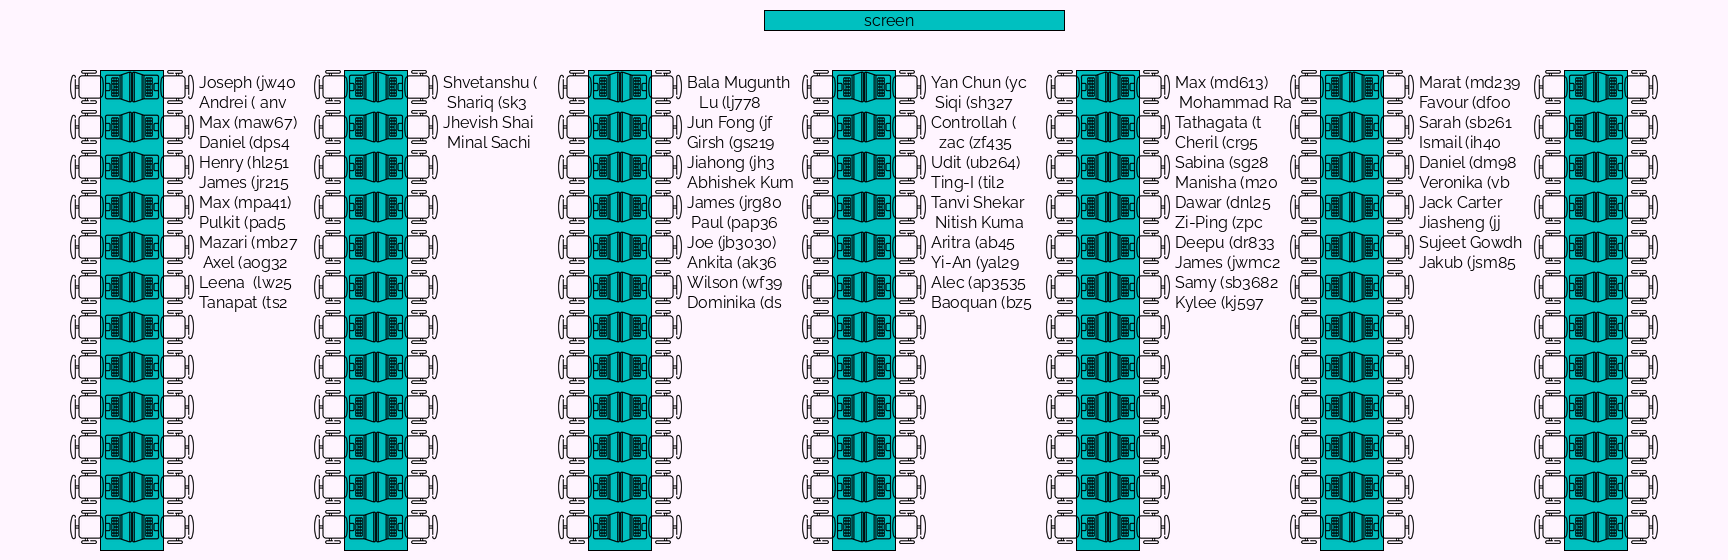

In [ ]:
#export

generated_visualisation = visualise_chart('expressive')
generated_visualisation.save('sitting_arrangement.jpg')
generated_visualisation

### Attribution

Font:

- `Raleway` font was used from `https://fonts.google.com/specimen/Raleway`

Icons (obtained freely from `flaticon`):

- `Chair icon` from `https://www.flaticon.com/free-icons/chair` created by `Freepik`

- `Computer icon` from `https://www.flaticon.com/free-icons/top-view` created by `Khoirul Huda`
